###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

Simple exploration of extraction techniques and some brief comparison

**Install the following packages:**

In [1]:
!pip install npTDMS
!pip install librosa

In [2]:
from nptdms import TdmsFile
import librosa
import librosa.display
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
from scipy.signal import decimate
import os
import pathlib

In [3]:
DATASETS = pathlib.Path(os.environ['DATASETS'])

In [4]:
def preprocess(data,fs,factor=6):
    data = decimate(data,factor)
    fs = int(fs/factor)
    return data,fs

def get_spectrogram(data,fs,n_fft=1024,hop_length=512,n_mels=128):
    data,fs = preprocess(data,fs,factor=6)
    spec = librosa.feature.melspectrogram(np.asfortranarray(data),sr=fs,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels)
    spec = librosa.power_to_db(spec)
    return spec

In [5]:
# Connect to DB
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd = "cuba",
    database = "airnoise"
)
print(mydb)

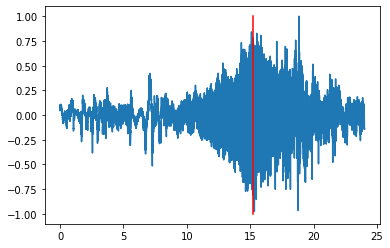

In [6]:
dbcursor = mydb.cursor()
fs = 51200
measurement = 15
array = 1
microphone = 1
sql = '''SELECT m.url, t.location FROM tmid t, measurements m WHERE t.measurement = {} AND
    t.array = {} AND t.microphone = {} AND m.id_measurement = t.measurement'''.format(
    measurement,array,microphone)
dbcursor.execute(sql)
result = dbcursor.fetchall()
url = result[0][0]
tmid = result[0][1]
root = pathlib.Path(DATASETS / "datasets/classification/noise/")
with TdmsFile.open(root / url.replace('\\','/')) as tdms:
    group = tdms['Untitled']
    channel = group['cDAQ1Mod' + str(array) + '/ai' + str(microphone - 1)]
    data = channel[:] / np.absolute(channel[:]).max()
    time = channel.time_track()
    plt.plot(time, data)
    plt.plot([tmid,tmid],[-1,1],'r-')

In [7]:
offset = 0
expand = 5
start = int((tmid+offset-expand)*fs)
end = int((tmid+offset+expand)*fs)
segment = data[start:end+1]

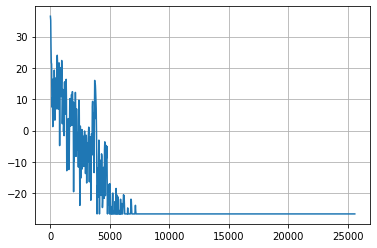

In [8]:
amp_spectrum = np.abs(librosa.stft(segment,n_fft=2048))
amp_spectrum = librosa.amplitude_to_db(amp_spectrum)
f = np.arange(1024 + 1)*((fs/2048))
plt.plot(f,amp_spectrum[:,0])
plt.grid()

(128, 167)

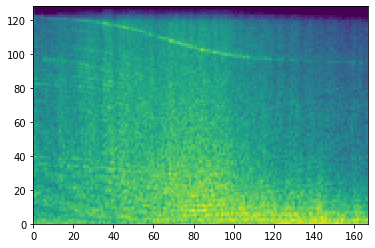

In [9]:
spec = get_spectrogram(segment,fs,n_fft=1024,hop_length=512,n_mels=128)
plt.pcolormesh(spec,cmap='viridis')
spec.shape

(128, 84)

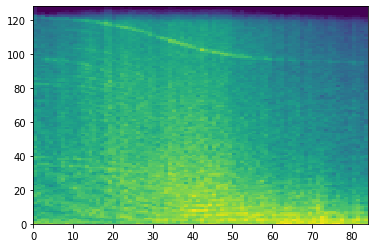

In [10]:
spec = get_spectrogram(segment,fs,n_fft=2048,hop_length=1024,n_mels=128)
plt.pcolormesh(spec,cmap='viridis')
spec.shape

In [11]:
%%timeit
lpc = librosa.core.lpc(segment, 100)

219 ms ± 51.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
librosa.feature.mfcc(segment, 100)

72.1 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
spec = get_spectrogram(segment, fs, n_fft=2048, hop_length=1024, n_mels=128)

13.2 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
